# Résolution de TPTW (travel problem with time window) avec métahéuristique du recuit simulé

In [19]:
# configuration
T_init = 1000
lbd = 0.999
nb_iter = 10000
path_to_instance = "data/inst1"

In [28]:
def evaluation_model(liste_prop, alpha=10):
    """
    évalue le modèle en fonction de la liste des propositions
    la formule choisie est la somme des distances plus une pénalité binaire pour chaque consigne de temps non respectée
    :rq: on utilise les variables globales instance et graphe_matrix
    """
    global instance, graphe_matrix
    score = 0
    assert liste_prop[0] == "1", "La première ville n'est pas 1 : {}".format(liste_prop)
    time_axis = 0
    valide = True
    for i, prop in enumerate(liste_prop):
        if i == 0: continue
        # on commence par aller jusqu'à la ville i
        time_axis += graphe_matrix[int(liste_prop[i-1])][int(liste_prop[i])]

        # si on est arrivé trop tôt, on attend
        if time_axis < instance[prop]["wstart"]:
            time_axis = instance[prop]["wstart"]

        # on ajoute le cout au score
        score += graphe_matrix[int(liste_prop[i-1])][int(prop)]

        # on ajoute une pénalité si on arrive trop tard (consigne de temps non respectée)
        if time_axis > instance[prop]["wend"]:
            score += alpha
            valide = False
    
    return score, valide

    

## préparation de l'instance pré-résolution

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from scoreEtudiant import *
from annexe import *
import tqdm

In [22]:
# calcul de la matrice des distances du graphe
instance = load_instance(path_to_instance)
graphe_matrix = compute_dist_mat(instance)


## Récuit simulé
On réalise ici l'algorithme du recuit-simulé.

In [46]:
# initialisation de l'algorithme
modele = list(instance.keys())
modele = ["1"] + random.sample(modele[1:], len(modele)-1)
print(modele)

temperature = T_init

modele_kept = modele.copy()
score_kept, valide = evaluation_model(modele_kept)
score_kept

# initialisation des historiques (pour affichage graphique ensuite)
historique_score = [score_kept]
historique_temperature = [temperature]
historique_score_kept = [score_kept]
historique_proba = [1]
historique_modele_valide = [valide]

['1', '7', '17', '15', '21', '2', '14', '3', '5', '19', '10', '8', '9', '12', '4', '6', '18', '11', '13', '20', '16']


In [47]:
for iteration in tqdm.tqdm(range(nb_iter)):
    # on commence par appliquer une transformation aléatoire
    modele = transformee_pick_2(modele)

    # on détermine le score du modèle ainsi modifié
    score, valide = evaluation_model(modele)

    # on accepte ou non la modification (recuit simulé)
    if score < score_kept:
        modele_kept = modele.copy()
        score_kept = score
    else:
        # la proba est calculée ici pour des soucis de cohérences avec les historiques
        proba = np.exp(-(score-score_kept)/temperature)
        if bernoulli.rvs(proba, size=1):    # variable de bernoulli
            modele_kept = modele.copy()
            score_kept = score

    # on met à jour les historiques
    historique_score.append(score)
    historique_temperature.append(temperature)
    historique_score_kept.append(score_kept)
    historique_proba.append(proba)
    historique_modele_valide.append(valide)

    # on met à jour la température puis ça repart
    temperature *= lbd
print("[INFO] Simulation terminée")
print("Meilleur score : ", score_kept)
print("Meilleur modèle : ", modele_kept)

100%|██████████| 10000/10000 [00:00<00:00, 14484.98it/s]

[INFO] Simulation terminée
Meilleur score :  504.0
Meilleur modèle :  ['1', '2', '3', '8', '17', '12', '9', '19', '18', '10', '14', '5', '21', '15', '7', '4', '13', '11', '6', '16', '20']


## Affichage des graphiques

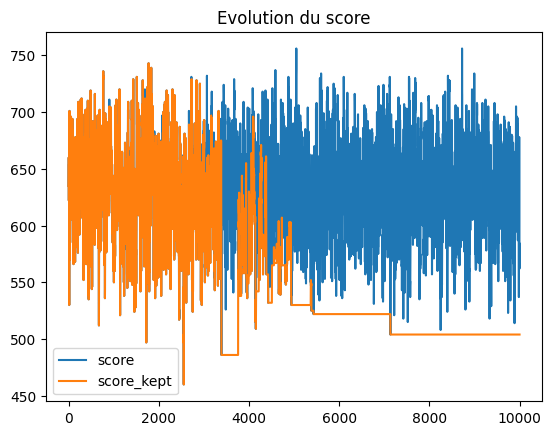

In [48]:
plt.plot(historique_score, label="score")
plt.plot(historique_score_kept, label="score_kept")
plt.title("Evolution du score")
plt.legend()

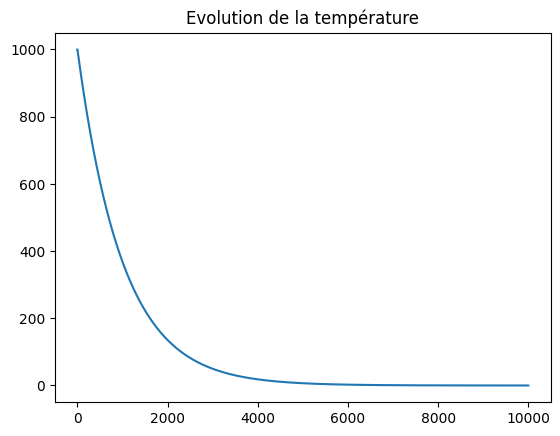

In [49]:
plt.close()
plt.plot(historique_temperature)
plt.title("Evolution de la température")
plt.show()

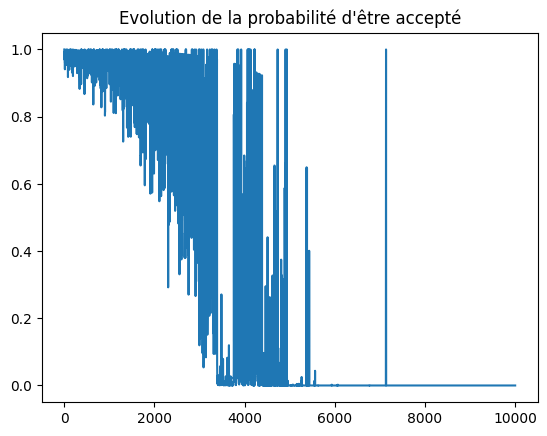

In [50]:
plt.close()
plt.plot(historique_proba)
plt.title("Evolution de la probabilité d'être accepté")
plt.show()

Text(0.5, 1.0, 'Evolution de la validité du modèle')

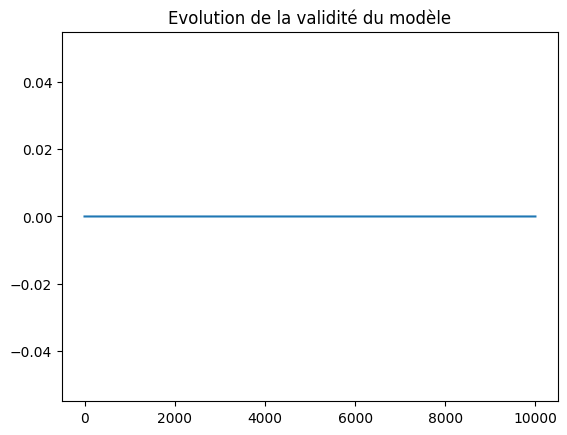

In [51]:
plt.close()
plt.plot(historique_modele_valide)
plt.title("Evolution de la validité du modèle")
